# K-Nearest Neighbors

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme()

## Pre-processing

Load and pre-process the dataset:

In [2]:
from lib import pre_processing
file_path = "./data/features_3_sec.csv"
df = pd.read_csv(file_path)
df = pre_processing(df)

## Data Normalization

In [3]:
from lib import normalize_df
df = normalize_df(df)

In [4]:
df_numpy = df.to_numpy()
X = df_numpy[:,:-1].astype(np.float32)
y = df_numpy[:, -1]

In [5]:
X.shape, y.shape

((9990, 57), (9990,))

## Model selection

We can tune two hyper-parameters: the number of neighbors and the weight function.

This has to be done both for the multiclass and the binary models.

In order to do so, we will use 20-fold cross-validation.

### Multiclass classifier

In [6]:
from sklearn.model_selection import KFold
from sklearn import neighbors

def cross_validate(X, y, n_splits, num_neighbours, weights):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=0)
    accuracy_list = []
    
    for train, test in kf.split(X):
        X_train, X_test, y_train, y_test = X[train], X[test], y[train], y[test]

        # Fit the model and compute predictions
        knn = neighbors.KNeighborsClassifier(num_neighbours, weights=weights)
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)

        accuracy = np.sum(y_test == y_pred) / len(y_test)
        accuracy_list.append(accuracy)
        
    return np.mean(accuracy_list)

In [7]:
weights = ('distance', 'uniform')
neighbours_values = np.arange(1, 21, 1)

distance_accuracy = []
for n in neighbours_values:
    #print(f'Neighbours: {i} - Accuracy: {cross_validate(20, i, X, y)}')
    distance_accuracy.append(cross_validate(X, y,20, n, 'distance'))

uniform_accuracy = []
for n in neighbours_values:
    #print(f'Neighbours: {i} - Accuracy: {cross_validate(20, i, X, y)}')
    uniform_accuracy.append(cross_validate(X, y, 20, n, 'uniform'))

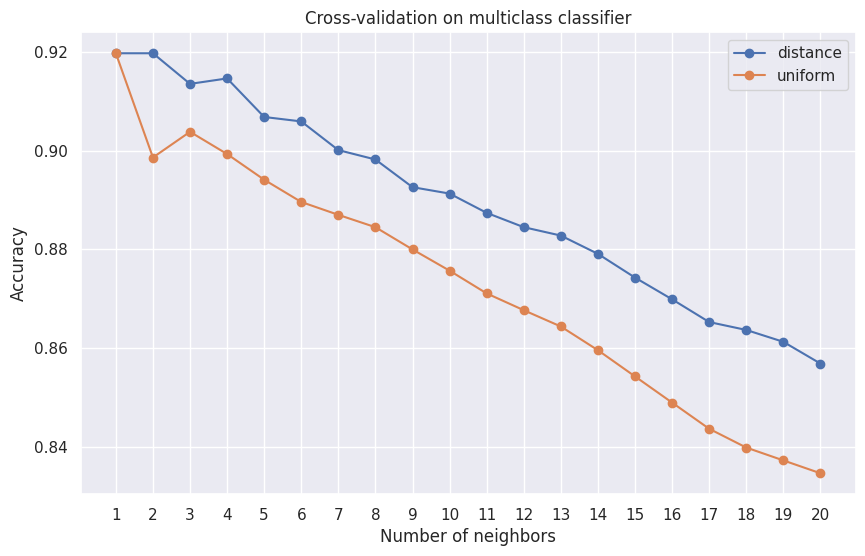

In [8]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,6))
ax.set_title('Cross-validation on multiclass classifier')
ax.plot(neighbours_values, distance_accuracy, '-o', label='distance')
ax.plot(neighbours_values, uniform_accuracy, '-o', label='uniform')
ax.set_xlabel('Number of neighbors')
ax.set_ylabel('Accuracy')
ax.set_xticks(neighbours_values)
ax.legend()

We can see that the best multiclass classifier is the one with the hyper-parameters:
- num_neighbors = 1
- weights = 'distance'
    
From now on, we will use that model.

### Binary classifiers

Given that binary classifiers are much more and have to tackle a simpler problem, we will use 10-fold cross-validation instead.

In [9]:
genres = ['blues', 'classical', 'country', 'disco', 'hiphop','jazz', 'metal', 'pop', 'reggae', 'rock']
weights = ('distance', 'uniform')
neighbours_values = np.arange(1, 16, 1)

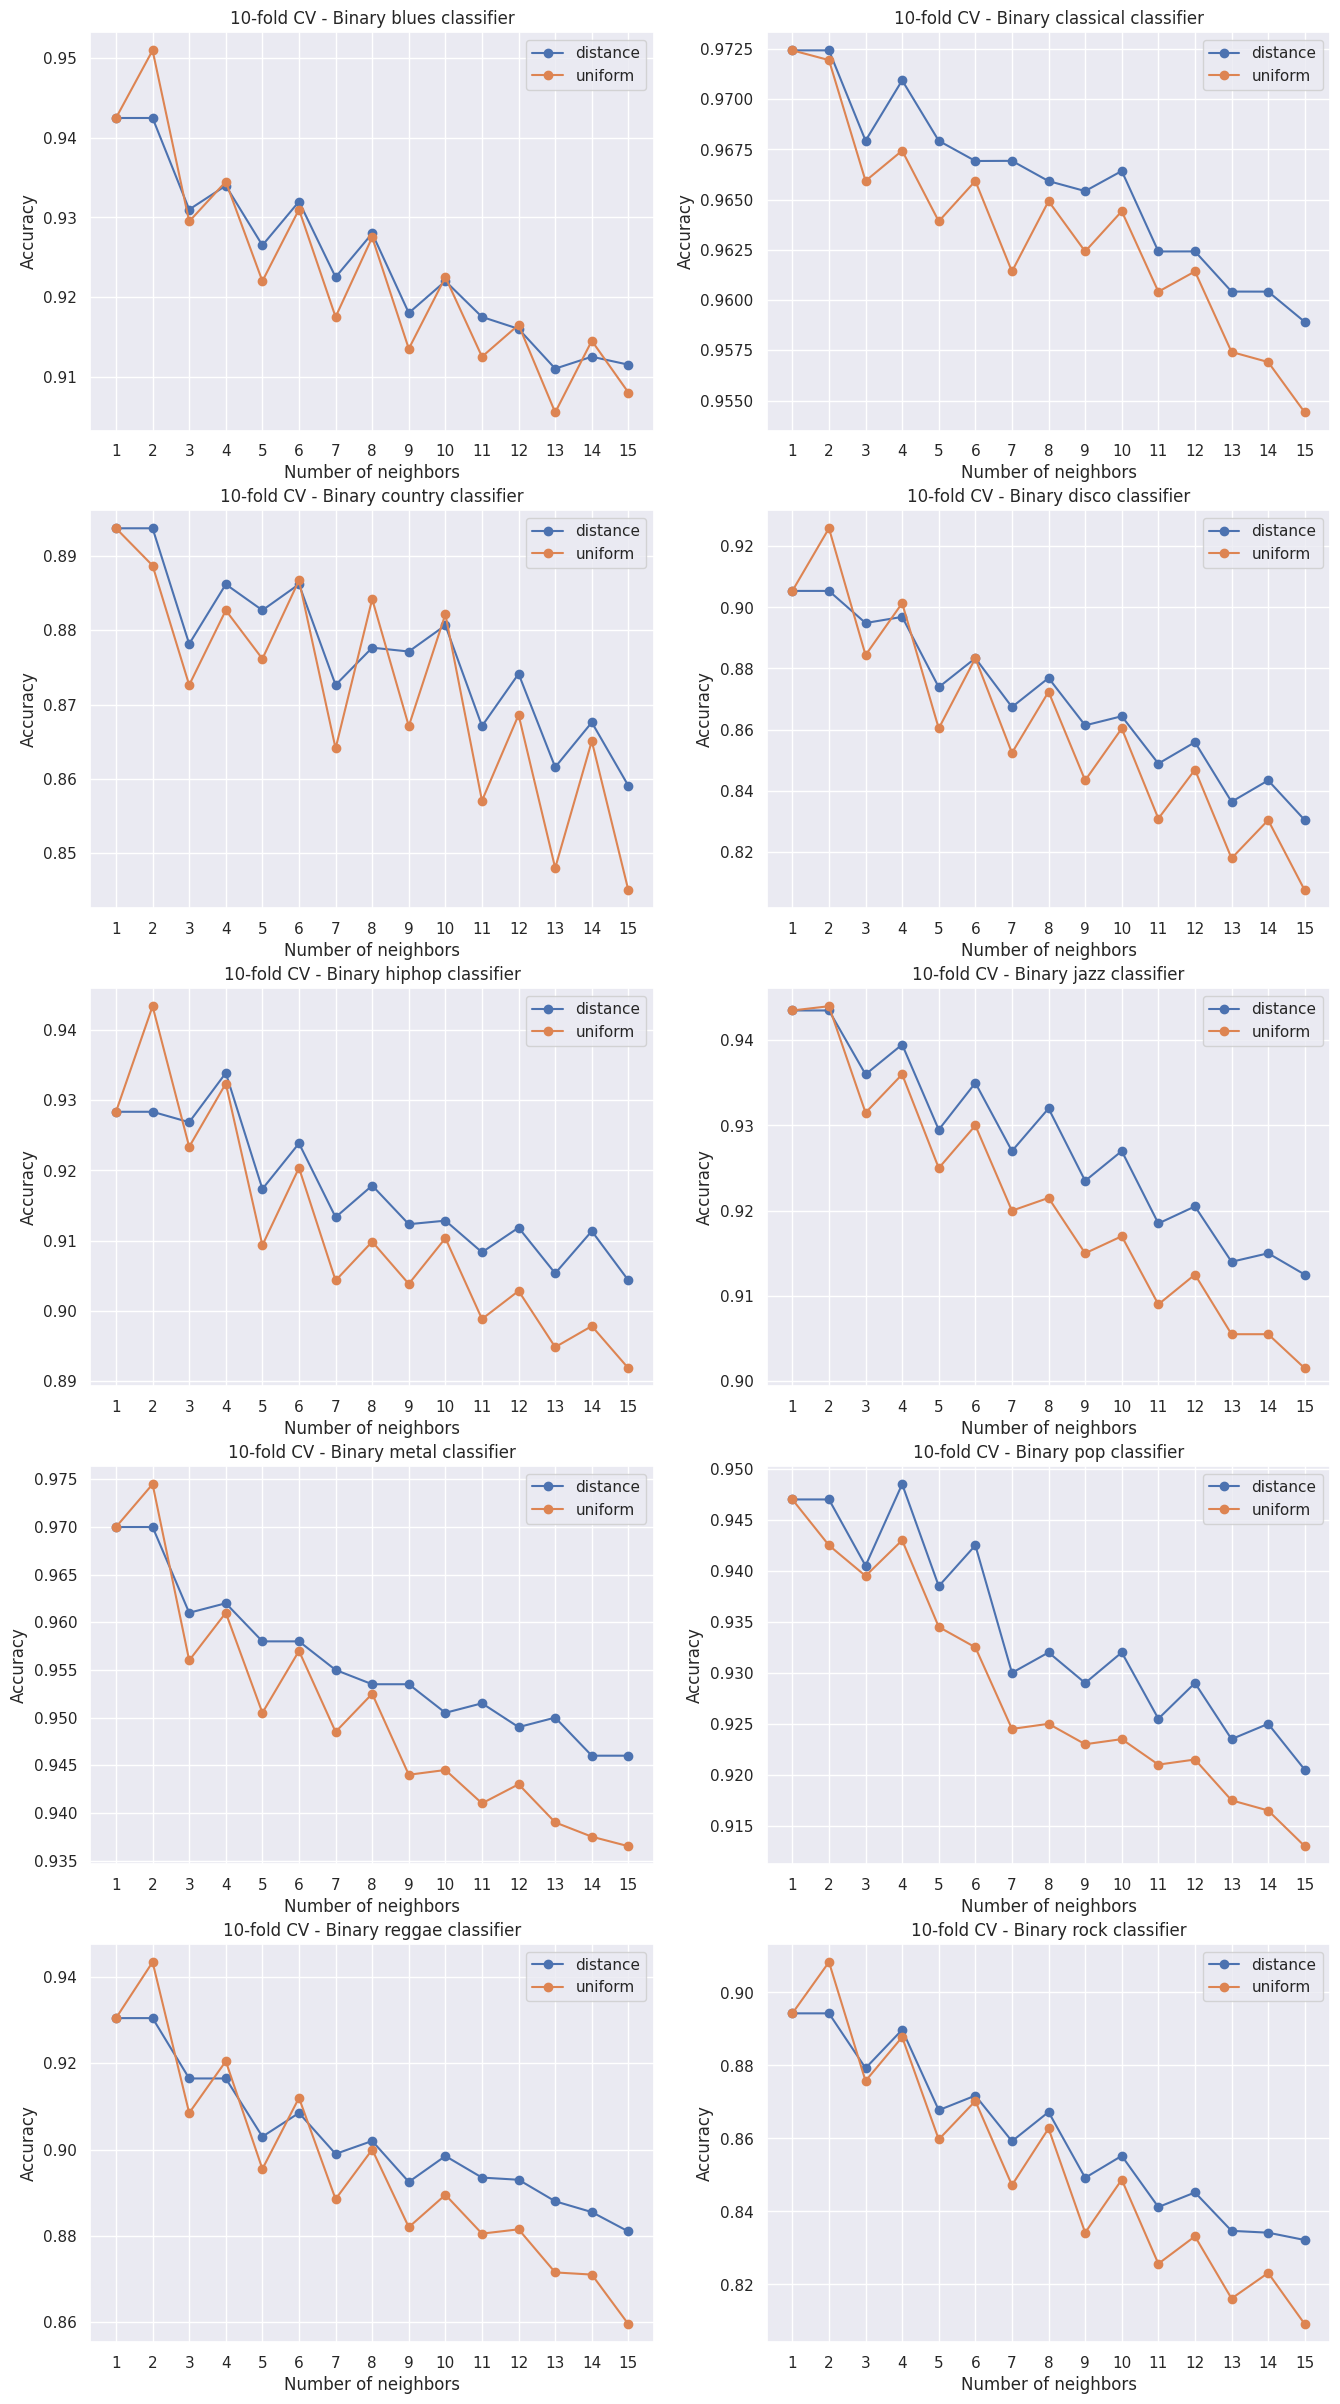

In [10]:
from lib import balance_classes

_, axs = plt.subplots(5, 2, figsize=(16,30))
axs = axs.flatten()

for i, genre in enumerate(genres):
    Xi, yi = balance_classes(X, y, genre, 0)
    distance_accuracy = []
    for n in neighbours_values:
        #print(f'Neighbours: {i} - Accuracy: {cross_validate(20, i, X, y)}')
        distance_accuracy.append(cross_validate(Xi, yi, 10, n, 'distance'))

    uniform_accuracy = []
    for n in neighbours_values:
        #print(f'Neighbours: {i} - Accuracy: {cross_validate(20, i, X, y)}')
        uniform_accuracy.append(cross_validate(Xi, yi, 10, n, 'uniform'))
            
    axs[i].set_title(f'10-fold CV - Binary {genre} classifier')
    axs[i].plot(neighbours_values, distance_accuracy, '-o', label='distance')
    axs[i].plot(neighbours_values, uniform_accuracy, '-o', label='uniform')
    axs[i].set_xlabel('Number of neighbors')
    axs[i].set_ylabel('Accuracy')
    axs[i].set_xticks(neighbours_values)
    axs[i].legend()

## Model Evaluation

### Multiclass classifier

In [11]:
from sklearn.model_selection import train_test_split

def fit_knn(X, y, test_size, n_neighbors, weights):
    # Train-validation split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=0)
    
    # Fit the model
    knn = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    
    # Return the accuracy
    return np.sum(y_test == y_pred) / len(y_test)

In [12]:
accuracy = fit_knn(X, y, 0.25,  1, 'distance')
print(f"| Genre: multiclass | Accuracy: {accuracy:.3%} |")

| Genre: multiclass | Accuracy: 90.833% |


### Balanced Binary Classifiers

In [13]:
genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

In [14]:
hyper_params = {
    'blues':     (2, 'uniform'),
    'classical': (1, 'distance'),
    'country':   (1, 'uniform'),
    'disco':     (2, 'uniform'),
    'hiphop':    (2, 'uniform'),
    'jazz':      (2, 'uniform'),
    'metal':     (2, 'uniform'),
    'pop':       (4, 'distance'),
    'reggae':    (2, 'uniform'),
    'rock':      (2, 'uniform')
}

In [15]:
from lib import balance_classes
for genre in genres:
    num_neighbors, weights = hyper_params[genre]
    Xi, yi = balance_classes(X, y, genre)
    accuracy = fit_knn(Xi, yi, 0.25, num_neighbors, weights)
    print(f"| Genre: {genre:9} | Accuracy: {accuracy:.3%} |")

| Genre: blues     | Accuracy: 94.800% |
| Genre: classical | Accuracy: 96.393% |
| Genre: country   | Accuracy: 86.373% |
| Genre: disco     | Accuracy: 91.600% |
| Genre: hiphop    | Accuracy: 92.986% |
| Genre: jazz      | Accuracy: 92.600% |
| Genre: metal     | Accuracy: 96.600% |
| Genre: pop       | Accuracy: 93.000% |
| Genre: reggae    | Accuracy: 93.200% |
| Genre: rock      | Accuracy: 87.174% |


## Static partitioning (train-validation split)

In [16]:
test_sizes = [0.1, 0.25, 0.33]

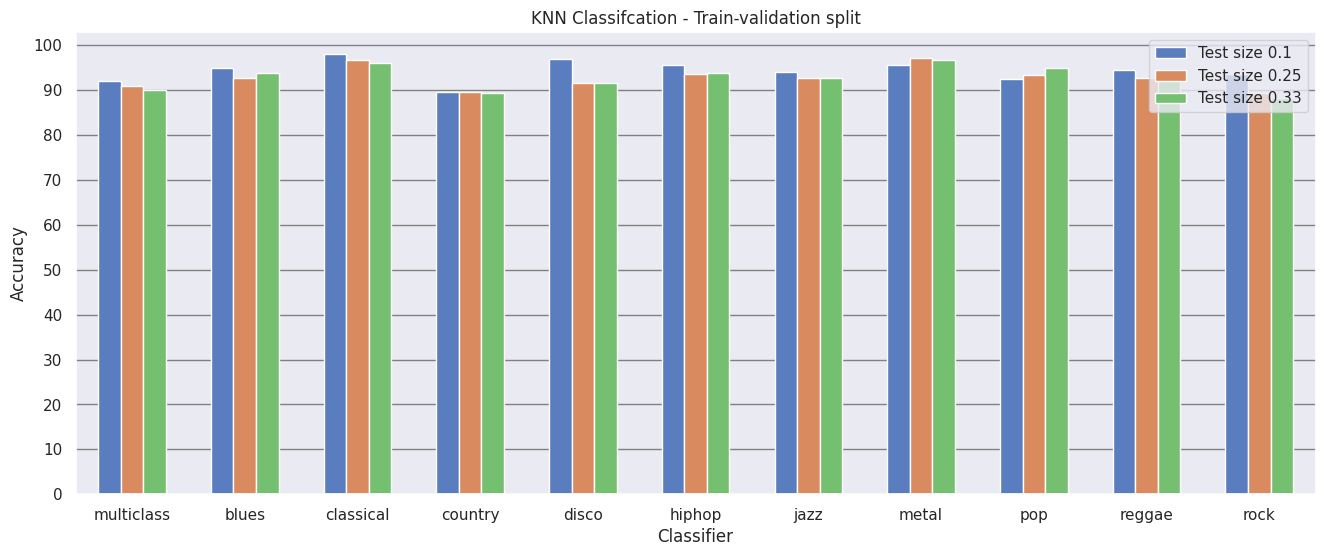

In [17]:
from lib import plot_evaluation_results
sp_results = []

for test_size in test_sizes:
    # Multiclass classifier
    accuracy = fit_knn(X, y, test_size, 1, 'uniform')
    sp_results.append(('multiclass', accuracy*100, f'Test size {test_size}'))
    
    # Binary classifiers
    for genre in genres:
        num_neighbors, weights = hyper_params[genre]
        Xi, yi = balance_classes(X, y, genre)
        accuracy = fit_knn(Xi, yi, test_size, num_neighbors, weights)
        sp_results.append((genre, accuracy*100, f'Test size {test_size}'))
    
# Plot
results_df = pd.DataFrame(sp_results, columns=['label', 'accuracy', 'size'])
plot_evaluation_results(results_df, f"KNN Classification - Train-validation split")

## Dynamic partitioning (cross-validation)

In [18]:
folds = [5, 10, 20]

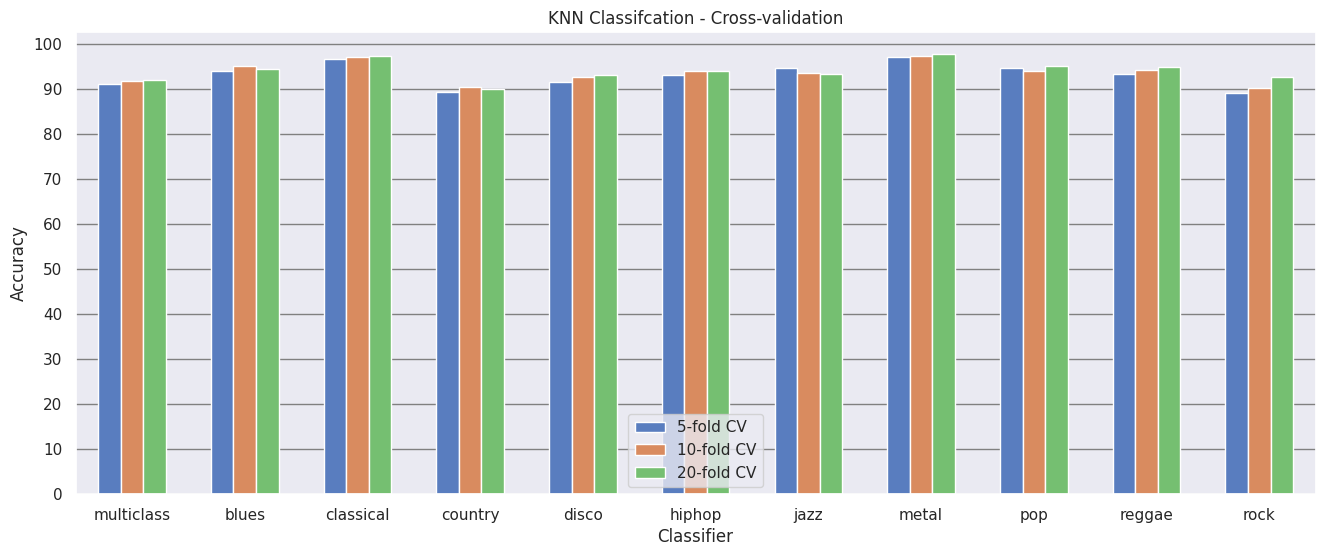

In [19]:
sp_results = []

for fold in folds:
    # Multiclass classifier
    accuracy = cross_validate(X, y, fold, 1, 'uniform')
    sp_results.append(('multiclass', accuracy*100, f'{fold}-fold CV'))
    
    # Binary classifiers
    for genre in genres:
        num_neighbors, weights = hyper_params[genre]
        Xi, yi = balance_classes(X, y, genre)
        accuracy = cross_validate(Xi, yi, fold, num_neighbors, weights)
        sp_results.append((genre, accuracy*100, f'{fold}-fold CV'))
    
# Plot
results_df = pd.DataFrame(sp_results, columns=['label', 'accuracy', 'size'])   
plot_evaluation_results(results_df, f"KNN Classification - Cross-validation")

# Multiclass confusion matrix

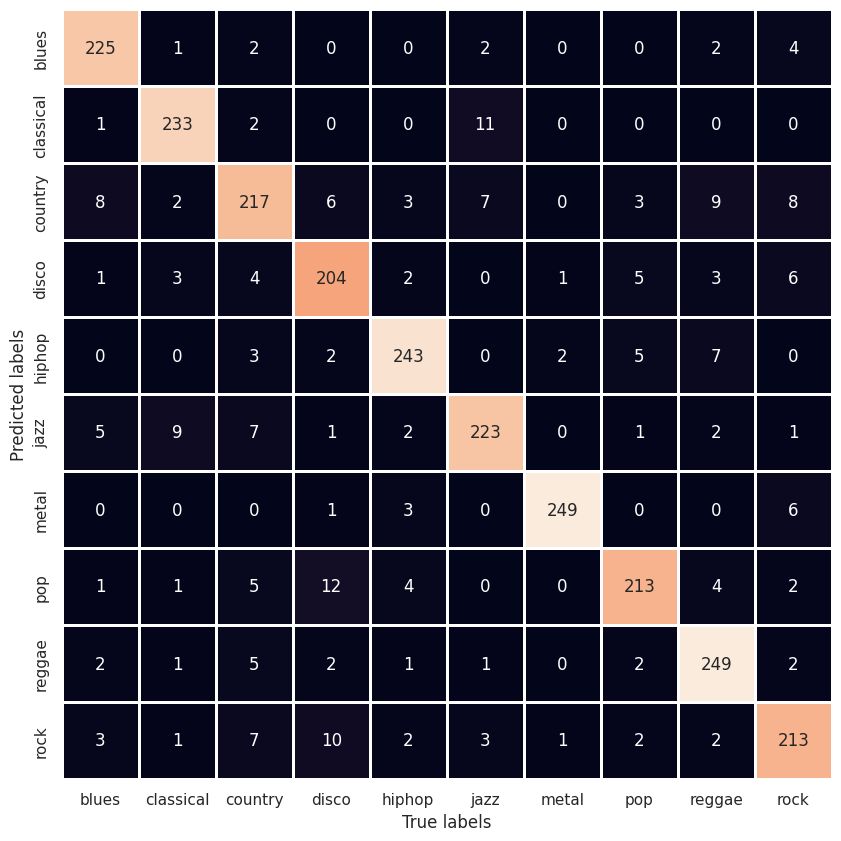

In [21]:
from lib import plot_confusion_matrix
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
knn = neighbors.KNeighborsClassifier(1, weights='uniform')
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
plot_confusion_matrix(y_test, y_pred, genres)